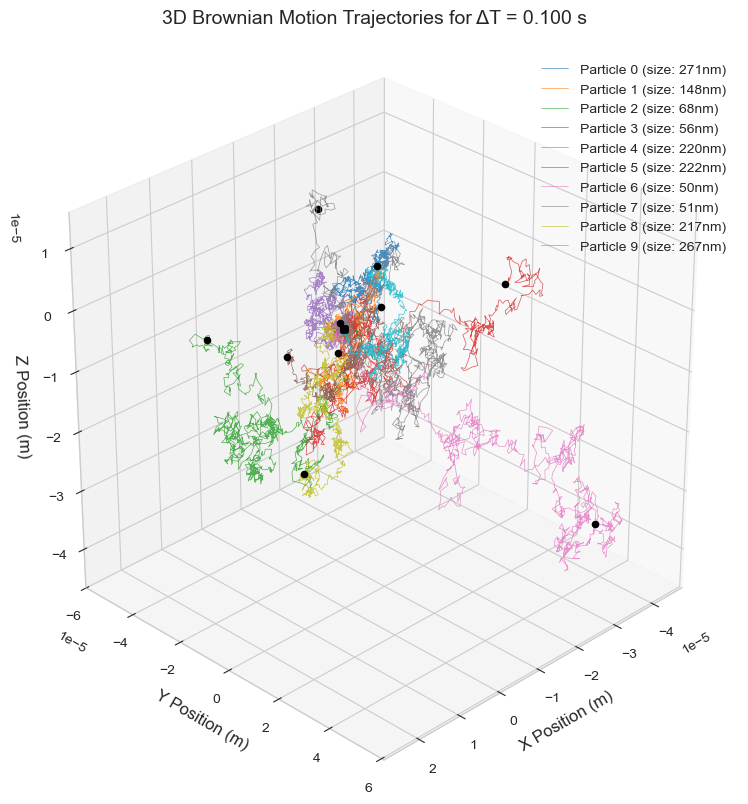

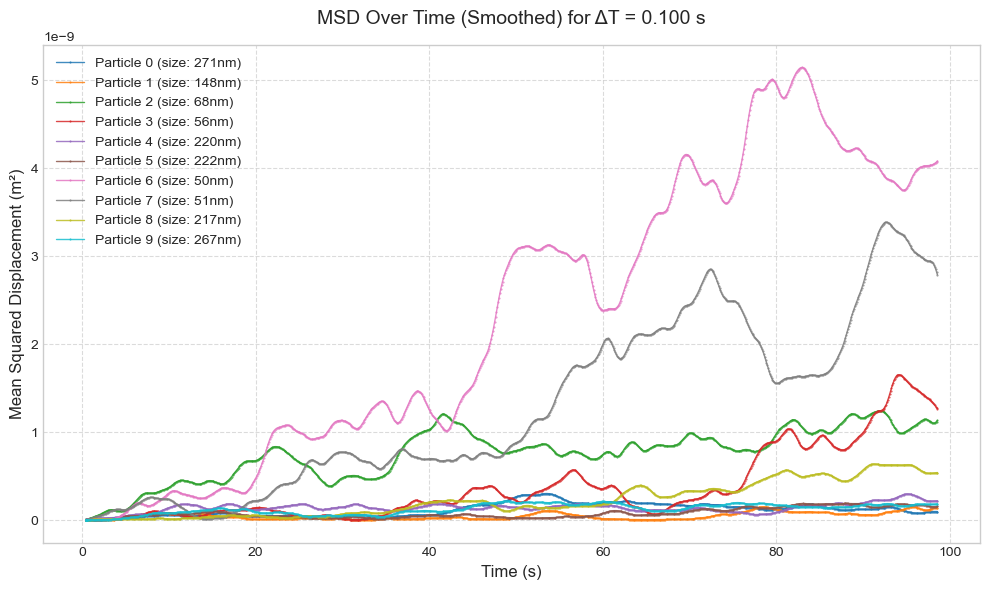

In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Use a clean style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Folder where the CSV files are located
folder_path = r"D:/Thesis_Workspace/Main_Cplusplus/brownian_v1.6_copy_oneInterval/notFinal"  # Adjust as needed

def format_particle_size(size):
    """
    Convert a particle size from meters to nanometers and return a string in layman's terms.
    For example, if the particle size is 2.8e-8 m, it returns "28nm".
    If the conversion fails, returns "Unknown".
    """
    try:
        size_float = float(size)
        size_nm = size_float * 1e9  # Convert meters to nanometers
        return f"{size_nm:.0f}nm"
    except (ValueError, TypeError):
        return "Unknown"

#############################################
# 1. 3D Trajectory Plots per ΔT             #
#############################################

# Find files that start with "traj_dt" and end with ".csv"
traj_pattern = os.path.join(folder_path, "traj_dt*.csv")
traj_csv_files = glob.glob(traj_pattern)

if not traj_csv_files:
    print("No trajectory CSV files found in:", folder_path)
else:
    # Group files by ΔT value extracted from filename (e.g. "traj_dt0.01.csv")
    dt_groups = {}
    for csv_file in traj_csv_files:
        basename = os.path.basename(csv_file)
        dt_val = basename.replace("traj_dt", "").replace(".csv", "")
        dt_groups.setdefault(dt_val, []).append(csv_file)

    for dt_val in sorted(dt_groups.keys(), key=lambda x: float(x)):
        # Combine all trajectory data for this ΔT value
        df_all = pd.concat([pd.read_csv(f) for f in dt_groups[dt_val]], ignore_index=True)
        
        # Group data by particle; each group contains all trajectory points for that particle.
        grouped = df_all.groupby("particle")
        particles = sorted(df_all["particle"].unique())
        cmap = plt.get_cmap("tab10", len(particles))
        particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        
        # Plot each particle's trajectory.
        for p, group in grouped:
            if "time" in group.columns:
                group = group.sort_values("time")
            raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
            particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
            label = f"Particle {p} (size: {particle_size})"
            
            ax.plot(group["x"], group["y"], group["z"],
                    color=particle_colors[p], alpha=0.8, linewidth=0.5,
                    label=label)
            # Mark the starting point (yellow square)
            ax.scatter(group["x"].iloc[0],
                       group["y"].iloc[0],
                       group["z"].iloc[0],
                       color="black", marker="s", s=20, zorder=5)
            # Mark the ending point (black circle)
            ax.scatter(group["x"].iloc[-1],
                       group["y"].iloc[-1],
                       group["z"].iloc[-1],
                       color="black", marker="o", s=20, zorder=5)
        
        ax.set_xlabel("X Position (m)", fontsize=12)
        ax.set_ylabel("Y Position (m)", fontsize=12)
        ax.set_zlabel("Z Position (m)", fontsize=12)
        ax.set_title(f"3D Brownian Motion Trajectories for ΔT = {float(dt_val):.3f} s", 
                     fontsize=14, pad=20)
        ax.view_init(elev=30, azim=45)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"trajectory_dt_{dt_val}.png", dpi=300)

#############################################
# 2. MSD Line Charts per ΔT                 #
#############################################

# Find files that start with "msd_dt" and end with ".csv"
msd_pattern = os.path.join(folder_path, "msd_dt*.csv")
msd_files = glob.glob(msd_pattern)

def smooth_data(series, window=10, iterations=3):
    """Smooths a data series using a rolling mean."""
    for _ in range(iterations):
        series = series.rolling(window=window).mean().bfill()
    return series

if not msd_files:
    print("No MSD CSV files found in:", folder_path)
else:
    # Group MSD files by ΔT value (e.g. "msd_dt0.01.csv")
    msd_dt_groups = {}
    for msd_file in msd_files:
        basename = os.path.basename(msd_file)
        dt_val = basename.replace("msd_dt", "").replace(".csv", "")
        msd_dt_groups.setdefault(dt_val, []).append(msd_file)
    
    for dt_val in sorted(msd_dt_groups.keys(), key=lambda x: float(x)):
        # Combine all MSD data for this ΔT value
        df_msd_all = pd.concat([pd.read_csv(f) for f in msd_dt_groups[dt_val]], ignore_index=True)
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if "particle" in df_msd_all.columns:
            # Plot each particle separately.
            particles = sorted(df_msd_all["particle"].unique())
            cmap = plt.get_cmap("tab10", len(particles))
            particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
            for p, group in df_msd_all.groupby("particle"):
                group = group.sort_values("time").copy()
                group["smoothed_time"] = smooth_data(group["time"])
                group["smoothed_msd"] = smooth_data(group["msd"])
                raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
                particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
                ax.plot(group["smoothed_time"], group["smoothed_msd"],
                        color=particle_colors[p],
                        label=f"Particle {p} (size: {particle_size})",
                        linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        else:
            # Otherwise, plot a single curve for the entire ΔT group.
            df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
            df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
            ax.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
                    label=f"MSD dt={dt_val}", linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
        ax.set_title(f"MSD Over Time (Smoothed) for ΔT = {float(dt_val):.3f} s", fontsize=14, pad=15)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"msd_dt_{dt_val}.png", dpi=300)

# Finally, display all figures.
plt.show()


D:/Thesis_Workspace/Main_Cplusplus/Final_oneInterval

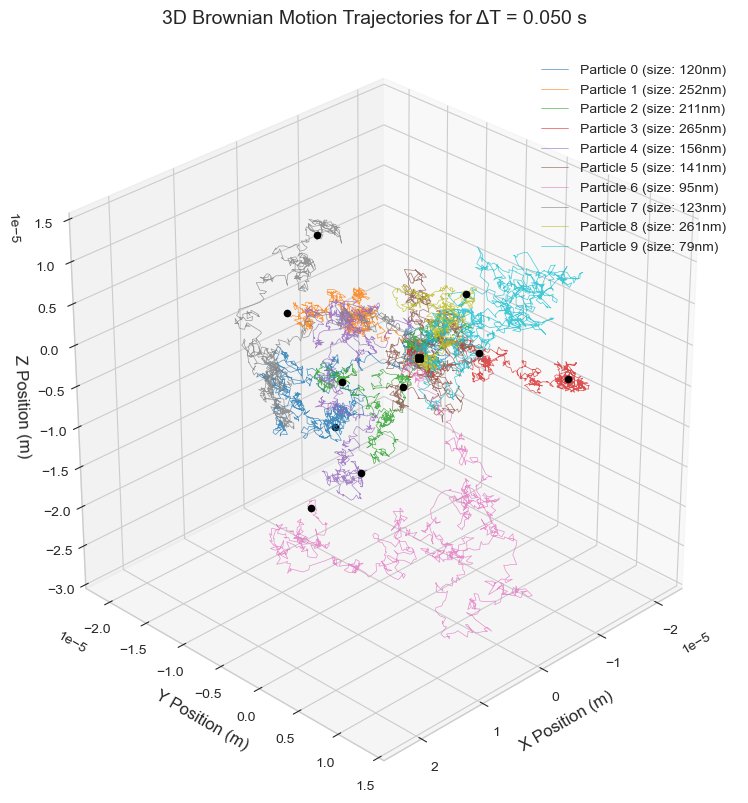

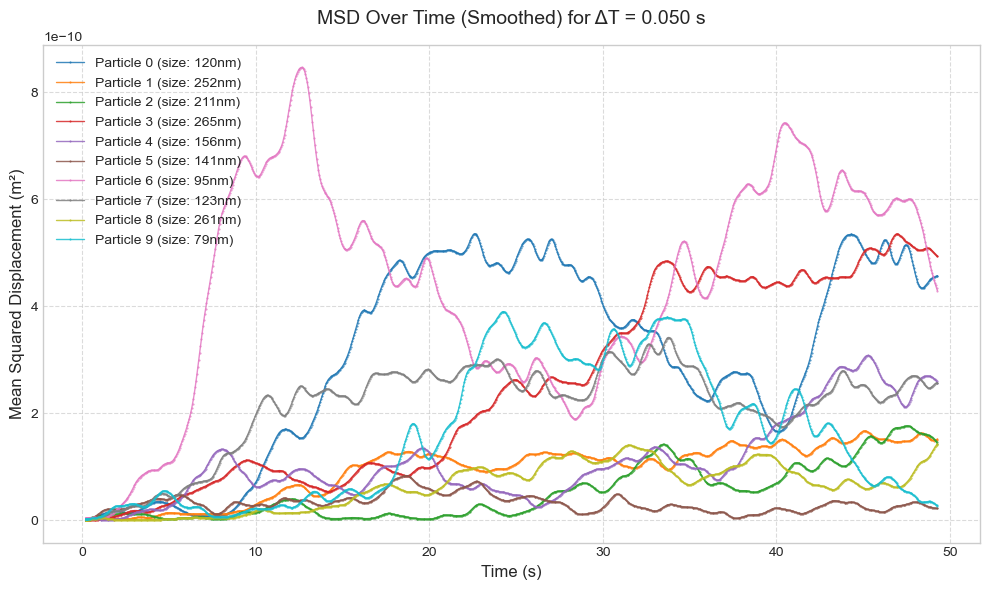

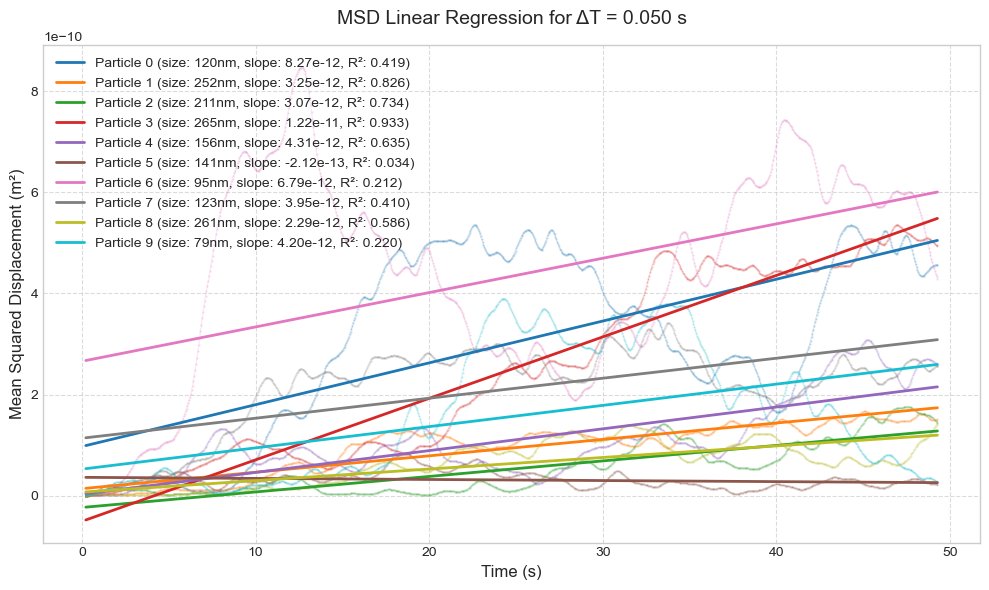

In [27]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Use a clean style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Folder where the CSV files are located
folder_path = r"D:/Thesis_Workspace/Main_Cplusplus/Final_oneInterval"  # Adjust as needed

def format_particle_size(size):
    """
    Convert a particle size from meters to nanometers and return a string in layman's terms.
    For example, if the particle size is 2.8e-8 m, it returns "28nm".
    If the conversion fails, returns "Unknown".
    """
    try:
        size_float = float(size)
        size_nm = size_float * 1e9  # Convert meters to nanometers
        return f"{size_nm:.0f}nm"
    except (ValueError, TypeError):
        return "Unknown"

#############################################
# 1. 3D Trajectory Plots per ΔT             #
#############################################

# Find files that start with "traj_dt" and end with ".csv"
traj_pattern = os.path.join(folder_path, "traj_dt*.csv")
traj_csv_files = glob.glob(traj_pattern)

if not traj_csv_files:
    print("No trajectory CSV files found in:", folder_path)
else:
    # Group files by ΔT value extracted from filename (e.g. "traj_dt0.01.csv")
    dt_groups = {}
    for csv_file in traj_csv_files:
        basename = os.path.basename(csv_file)
        dt_val = basename.replace("traj_dt", "").replace(".csv", "")
        dt_groups.setdefault(dt_val, []).append(csv_file)

    for dt_val in sorted(dt_groups.keys(), key=lambda x: float(x)):
        # Combine all trajectory data for this ΔT value
        df_all = pd.concat([pd.read_csv(f) for f in dt_groups[dt_val]], ignore_index=True)
        
        # Group data by particle; each group contains all trajectory points for that particle.
        grouped = df_all.groupby("particle")
        particles = sorted(df_all["particle"].unique())
        cmap = plt.get_cmap("tab10", len(particles))
        particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
        
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection="3d")
        
        # Plot each particle's trajectory.
        for p, group in grouped:
            if "time" in group.columns:
                group = group.sort_values("time")
            raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
            particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
            label = f"Particle {p} (size: {particle_size})"
            
            ax.plot(group["x"], group["y"], group["z"],
                    color=particle_colors[p], alpha=0.8, linewidth=0.5,
                    label=label)
            # Mark the starting point (yellow square)
            ax.scatter(group["x"].iloc[0],
                       group["y"].iloc[0],
                       group["z"].iloc[0],
                       color="black", marker="s", s=20, zorder=5)
            # Mark the ending point (black circle)
            ax.scatter(group["x"].iloc[-1],
                       group["y"].iloc[-1],
                       group["z"].iloc[-1],
                       color="black", marker="o", s=20, zorder=5)
        
        ax.set_xlabel("X Position (m)", fontsize=12)
        ax.set_ylabel("Y Position (m)", fontsize=12)
        ax.set_zlabel("Z Position (m)", fontsize=12)
        ax.set_title(f"3D Brownian Motion Trajectories for ΔT = {float(dt_val):.3f} s", 
                     fontsize=14, pad=20)
        ax.view_init(elev=30, azim=45)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"trajectory_dt_{dt_val}.png", dpi=300)

#############################################
# 2. MSD Line Charts per ΔT                 #
#############################################

# Find files that start with "msd_dt" and end with ".csv"
msd_pattern = os.path.join(folder_path, "msd_dt*.csv")
msd_files = glob.glob(msd_pattern)

def smooth_data(series, window=10, iterations=3):
    """Smooths a data series using a rolling mean."""
    for _ in range(iterations):
        series = series.rolling(window=window).mean().bfill()
    return series

if not msd_files:
    print("No MSD CSV files found in:", folder_path)
else:
    # Group MSD files by ΔT value (e.g. "msd_dt0.01.csv")
    msd_dt_groups = {}
    for msd_file in msd_files:
        basename = os.path.basename(msd_file)
        dt_val = basename.replace("msd_dt", "").replace(".csv", "")
        msd_dt_groups.setdefault(dt_val, []).append(msd_file)
    
    for dt_val in sorted(msd_dt_groups.keys(), key=lambda x: float(x)):
        # Combine all MSD data for this ΔT value
        df_msd_all = pd.concat([pd.read_csv(f) for f in msd_dt_groups[dt_val]], ignore_index=True)
        
        # Create the original MSD plot
        fig, ax = plt.subplots(figsize=(10, 6))
        
        if "particle" in df_msd_all.columns:
            # Plot each particle separately.
            particles = sorted(df_msd_all["particle"].unique())
            cmap = plt.get_cmap("tab10", len(particles))
            particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
            for p, group in df_msd_all.groupby("particle"):
                group = group.sort_values("time").copy()
                group["smoothed_time"] = smooth_data(group["time"])
                group["smoothed_msd"] = smooth_data(group["msd"])
                raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
                particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
                ax.plot(group["smoothed_time"], group["smoothed_msd"],
                        color=particle_colors[p],
                        label=f"Particle {p} (size: {particle_size})",
                        linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        else:
            # Otherwise, plot a single curve for the entire ΔT group.
            df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
            df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
            ax.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
                    label=f"MSD dt={dt_val}", linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
        ax.set_title(f"MSD Over Time (Smoothed) for ΔT = {float(dt_val):.3f} s", fontsize=14, pad=15)
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(fontsize=10)
        fig.tight_layout()
        # Optionally, save the figure:
        # fig.savefig(f"msd_dt_{dt_val}.png", dpi=300)
        
        # Create a new figure for linear regression analysis
fig_regression, ax_regression = plt.subplots(figsize=(10, 6))

if "particle" in df_msd_all.columns:
    # Plot each particle with its regression line only
    particles = sorted(df_msd_all["particle"].unique())
    cmap = plt.get_cmap("tab10", len(particles))
    particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
    for p, group in df_msd_all.groupby("particle"):
        group = group.sort_values("time").copy()
        
        # Original smoothed data points
        group["smoothed_time"] = smooth_data(group["time"])
        group["smoothed_msd"] = smooth_data(group["msd"])
        
        # Plot the MSD data in the background with low opacity
        ax_regression.plot(group["smoothed_time"], group["smoothed_msd"],
                color=particle_colors[p], linewidth=1, 
                alpha=0.15, zorder=1, marker='o', markersize=0.8)
        
        # Perform linear regression
        slope, intercept, r_value, p_value, std_err = stats.linregress(
            group["smoothed_time"], group["smoothed_msd"]
        )
        
        # Calculate R-squared
        r_squared = r_value**2
        
        # Create regression line
        x_reg = np.linspace(group["smoothed_time"].min(), group["smoothed_time"].max(), 100)
        y_reg = slope * x_reg + intercept
        
        # Format particle information
        raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
        particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
        
        # Plot regression line - in the foreground with higher zorder
        ax_regression.plot(x_reg, y_reg, color=particle_colors[p],
                label=f"Particle {p} (size: {particle_size}, slope: {slope:.2e}, R²: {r_squared:.3f})", 
                linewidth=2, zorder=2)
else:
    # Single curve regression for entire dt group
    df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
    df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
    
    # Plot the MSD data in the background with low opacity
    ax_regression.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
            linewidth=2, alpha=0.15, zorder=1, marker='o', markersize=0.5)
    
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"]
    )
    
    # Calculate R-squared
    r_squared = r_value**2
    
    # Create regression line
    x_reg = np.linspace(df_msd_all["smoothed_time"].min(), df_msd_all["smoothed_time"].max(), 100)
    y_reg = slope * x_reg + intercept
    
    # Plot regression line - in the foreground
    ax_regression.plot(x_reg, y_reg, linewidth=1, zorder=2,
            label=f"MSD dt={dt_val}, slope: {slope:.2e}, R²: {r_squared:.3f}")

# Configure the regression plot
ax_regression.set_xlabel("Time (s)", fontsize=12)
ax_regression.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
ax_regression.set_title(f"MSD Linear Regression for ΔT = {float(dt_val):.3f} s", fontsize=14, pad=15)
ax_regression.grid(True, linestyle='--', alpha=0.7)
ax_regression.legend(fontsize=10)
fig_regression.tight_layout()

# Finally, display all figures.
plt.show()

run,num_particles,num_steps,run_time_s
0,10,1000,0.259476 -- 0.1 time_interval

run,num_particles,num_steps,run_time_s
0,100000,100,288.005 -- 0.05 time_interval & 1000000 particles


Looking for trajectory files in: D:/Thesis_Workspace/Main_Cplusplus/Final_oneInterval
Found 1 trajectory files


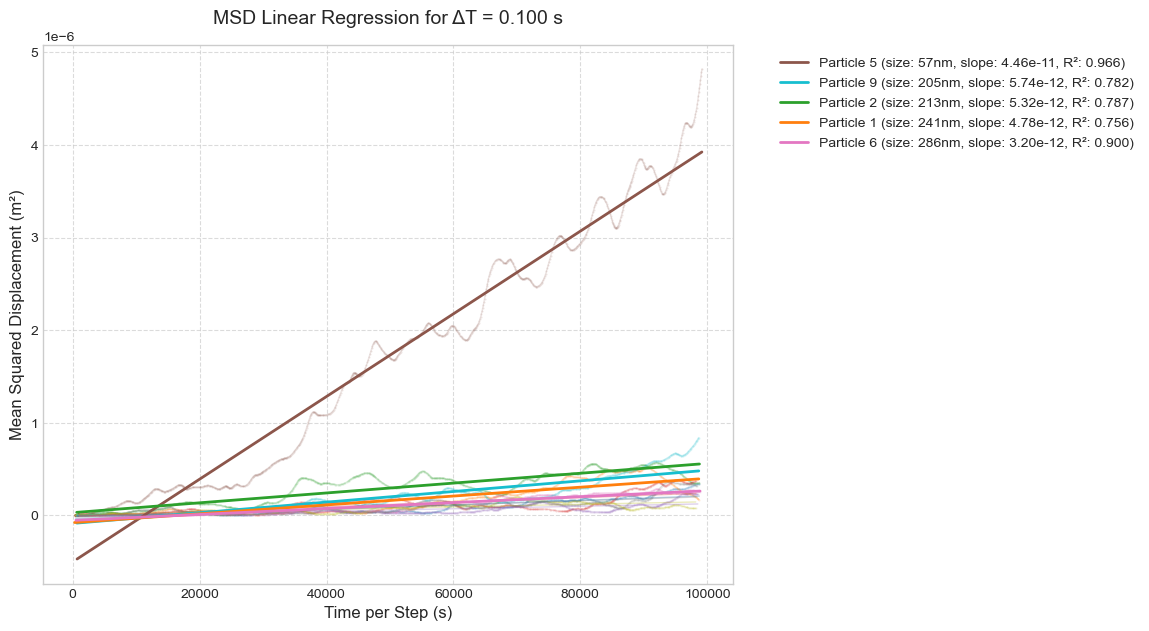

In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import gc

# Use a clean style for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Folder where the CSV files are located
folder_path = r"D:/Thesis_Workspace/Main_Cplusplus/Final_oneInterval"  # Adjust as needed

def format_particle_size(size):
    """
    Convert a particle size from meters to nanometers and return a string in layman's terms.
    For example, if the particle size is 2.8e-8 m, it returns "28nm".
    If the conversion fails, returns "Unknown".
    """
    try:
        size_float = float(size)
        size_nm = size_float * 1e9  # Convert meters to nanometers
        return f"{size_nm:.0f}nm"
    except (ValueError, TypeError):
        return "Unknown"

# Function to read large CSV files in chunks
def load_large_csv(file_path, chunksize=10000):
    """Reads large CSV files in chunks to reduce memory usage."""
    chunks = []
    try:
        for chunk in pd.read_csv(file_path, chunksize=chunksize):
            chunks.append(chunk)
        return pd.concat(chunks) if chunks else pd.DataFrame()
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return pd.DataFrame()

# Calculate the total distance traveled by a particle
def calculate_trajectory_distance(group):
    """Calculate the total distance traveled along a trajectory"""
    if len(group) <= 1:
        return 0
    
    # Calculate distance between consecutive points and sum them
    dx = group['x'].diff()
    dy = group['y'].diff()
    dz = group['z'].diff()
    distances = np.sqrt(dx**2 + dy**2 + dz**2)
    return distances.sum()

#############################################
# 1. 3D Trajectory Plots per ΔT             #
#############################################

# Find files that start with "traj_dt" and end with ".csv"
traj_pattern = os.path.join(folder_path, "traj_dt*.csv")
traj_csv_files = glob.glob(traj_pattern)
print(f"Looking for trajectory files in: {folder_path}")
print(f"Found {len(traj_csv_files)} trajectory files")

if not traj_csv_files:
    print("No trajectory CSV files found in:", folder_path)
else:
    # Group files by ΔT value extracted from filename (e.g. "traj_dt0.01.csv")
    dt_groups = {}
    for csv_file in traj_csv_files:
        basename = os.path.basename(csv_file)
        dt_val = basename.replace("traj_dt", "").replace(".csv", "")
        dt_groups.setdefault(dt_val, []).append(csv_file)

    for dt_val in sorted(dt_groups.keys(), key=lambda x: float(x)):
        # Combine all trajectory data for this ΔT value using our chunked loading function
        df_all = pd.concat([load_large_csv(f) for f in dt_groups[dt_val]], ignore_index=True)
        
        # Group data by particle; each group contains all trajectory points for that particle.
        grouped = df_all.groupby("particle")
        
        # Calculate trajectory distances for each particle
        particle_distances = {}
        particle_groups = {}  # Store grouped data for each particle
        
        for p, group in grouped:
            if "time" in group.columns:
                group = group.sort_values("time")
            particle_distances[p] = calculate_trajectory_distance(group)
            particle_groups[p] = group  # Store the sorted group
        
        # Get the top 5 particles with farthest trajectories
        top_5_particles = sorted(particle_distances.keys(), key=lambda p: particle_distances[p], reverse=True)[:5]
        
        # Setup for particle colors
        particles = sorted(df_all["particle"].unique())
        cmap = plt.get_cmap("tab10", len(particles))
        particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
        
        # Create figure
        fig = plt.figure(figsize=(12, 8))
        ax = fig.add_subplot(111, projection="3d")
        
        # Plot top 5 particles first, in order of distance (ensures correct legend order)
        for p in top_5_particles:  # This loop goes through particles in distance order
            group = particle_groups[p]
            raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
            particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
            
            # Add distance to the label
            label = f"Particle {p} (size: {particle_size}, dist: {particle_distances[p]:.2e}m)"
            
            # Plot trajectory line with higher visibility
            ax.plot(group["x"], group["y"], group["z"],
                    color=particle_colors[p], alpha=0.8, linewidth=1.0,
                    label=label)
            
            # Mark the starting point (black square)
            ax.scatter(group["x"].iloc[0], group["y"].iloc[0], group["z"].iloc[0],
                      color="black", marker="s", s=30, zorder=5)
                      
            # Mark the ending point (black circle)
            ax.scatter(group["x"].iloc[-1], group["y"].iloc[-1], group["z"].iloc[-1],
                      color="black", marker="o", s=30, zorder=5)
        
        # Now plot all other particles with reduced visibility
        for p, group in grouped:
            if p not in top_5_particles:
                ax.plot(group["x"], group["y"], group["z"],
                        color=particle_colors[p], alpha=0.3, linewidth=0.3,
                        label="_nolegend_")  # Exclude from legend
                # No markers for non-top-5 particles
        
        # Configure the plot
        ax.set_xlabel("X Position (m)", fontsize=12)
        ax.set_ylabel("Y Position (m)", fontsize=12)
        ax.set_zlabel("Z Position (m)", fontsize=12)
        ax.set_title(f"3D Brownian Motion Trajectories for ΔT = {float(dt_val):.3f} s", 
                     fontsize=14, pad=20)
        ax.view_init(elev=30, azim=45)
        try:
            ax.set_box_aspect((1, 1, 1))
        except Exception:
            pass
        
        # Add legend entries for the markers
        handles, labels = ax.get_legend_handles_labels()
        from matplotlib.lines import Line2D
        start_marker = Line2D([], [], color='black', marker='s', linestyle='None',
                           markersize=6, label='Starting Point')
        end_marker = Line2D([], [], color='black', marker='o', linestyle='None',
                           markersize=6, label='Ending Point')
        handles.extend([start_marker, end_marker])
        
        # Place legend outside the plot to avoid overcrowding
        ax.legend(handles=handles, fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
        fig.subplots_adjust(right=0.7)  # Make more room for the legend
        
        # Optionally, save the figure:
        fig.savefig(f"trajectory_dt_{dt_val}.png", dpi=300)
        
        # Uncomment these lines if you want to display the plots directly
        # plt.show()
        
        # Comment these lines if you want to display the plots
        plt.close(fig)  
        gc.collect()    

#############################################
# 2. MSD Line Charts per ΔT                 #
#############################################

# Find files that start with "msd_dt" and end with ".csv"
msd_pattern = os.path.join(folder_path, "msd_dt*.csv")
msd_files = glob.glob(msd_pattern)

def smooth_data(series, window=10, iterations=3):
    """Smooths a data series using a rolling mean."""
    for _ in range(iterations):
        series = series.rolling(window=window).mean().bfill()
    return series

def downsample(df, max_points=1000):
    """Downsample dataframe if it contains too many points"""
    if len(df) > max_points:
        return df.sample(max_points).sort_index()
    return df

if not msd_files:
    print("No MSD CSV files found in:", folder_path)
else:
    # Group MSD files by ΔT value (e.g. "msd_dt0.01.csv")
    msd_dt_groups = {}
    for msd_file in msd_files:
        basename = os.path.basename(msd_file)
        dt_val = basename.replace("msd_dt", "").replace(".csv", "")
        msd_dt_groups.setdefault(dt_val, []).append(msd_file)
    
    for dt_val in sorted(msd_dt_groups.keys(), key=lambda x: float(x)):
        # Combine all MSD data for this ΔT value using our chunked loading function
        df_msd_all = pd.concat([load_large_csv(f) for f in msd_dt_groups[dt_val]], ignore_index=True)
        
        # Create the original MSD plot
        fig, ax = plt.subplots(figsize=(12, 7))
        
        if "particle" in df_msd_all.columns:
            # Plot each particle separately.
            particles = sorted(df_msd_all["particle"].unique())
            cmap = plt.get_cmap("tab10", len(particles))
            particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
            for p, group in df_msd_all.groupby("particle"):
                # Downsample data if needed
                group = downsample(group.sort_values("time").copy())
                
                group["smoothed_time"] = smooth_data(group["time"])
                group["smoothed_msd"] = smooth_data(group["msd"])
                raw_size = group["particle_size"].iloc[0] if "particle_size" in group.columns else None
                particle_size = format_particle_size(raw_size) if raw_size is not None else "Unknown"
                ax.plot(group["smoothed_time"], group["smoothed_msd"],
                        color=particle_colors[p],
                        label=f"Particle {p} (size: {particle_size})",
                        linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        else:
            # Otherwise, plot a single curve for the entire ΔT group.
            df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
            df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
            ax.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
                    label=f"MSD dt={dt_val}", linewidth=1, marker='o', markersize=0.5, alpha=0.85)
        
        ax.set_xlabel("Time (s)", fontsize=12)
        ax.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
        ax.set_title(f"MSD Over Time (Smoothed) for ΔT = {float(dt_val):.3f} s", fontsize=14, pad=15)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Place legend outside of plot area
        ax.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
        fig.subplots_adjust(right=0.7)
        
        # Optionally, save the figure:
        # fig.savefig(f"msd_dt_{dt_val}.png", dpi=300)
        
        # Free memory
        plt.close(fig)
        gc.collect()
        
        # Create a new figure for linear regression analysis
        fig_regression, ax_regression = plt.subplots(figsize=(12, 7))

        if "particle" in df_msd_all.columns and "particle_size" in df_msd_all.columns:
            # Dictionary to store regression slopes
            particle_slopes = {}
            particle_data = {}  # Store data for each particle
            
            particles = sorted(df_msd_all["particle"].unique())
            cmap = plt.get_cmap("tab10", len(particles))
            particle_colors = {p: cmap(i) for i, p in enumerate(particles)}
            
            # First calculate all slopes and store data for each particle
            for p, group in df_msd_all.groupby("particle"):
                # Downsample data if needed
                group = downsample(group.sort_values("time").copy())
                
                # Smooth data
                group["smoothed_time"] = smooth_data(group["time"])
                group["smoothed_msd"] = smooth_data(group["msd"])
                
                # Perform linear regression
                slope, intercept, r_value, p_value, std_err = stats.linregress(
                    group["smoothed_time"], group["smoothed_msd"]
                )
                
                # Store slope and data
                particle_slopes[p] = slope
                particle_data[p] = {
                    "group": group,
                    "slope": slope,
                    "intercept": intercept,
                    "r_value": r_value,
                    "r_squared": r_value**2,
                    "size": group["particle_size"].iloc[0] if "particle_size" in group.columns else None
                }
                
                # Plot the MSD data in the background with low opacity
                ax_regression.plot(group["smoothed_time"], group["smoothed_msd"],
                        color=particle_colors[p], linewidth=1, 
                        alpha=0.15, zorder=1, marker='o', markersize=0.5)
                
                # Plot regression line for all particles with low visibility
                x_reg = np.linspace(group["smoothed_time"].min(), group["smoothed_time"].max(), 100)
                y_reg = slope * x_reg + intercept
                ax_regression.plot(x_reg, y_reg, color=particle_colors[p],
                        linewidth=1, zorder=2, alpha=0.3, label="_nolegend_")
                
            # Get top 5 particles with highest slopes
            top_5_slopes = sorted(particle_slopes.keys(), key=lambda p: particle_slopes[p], reverse=True)[:5]
            
            # Now add only the top 5 to the legend in order of slope
            for p in top_5_slopes:
                data = particle_data[p]
                
                # Format particle information
                particle_size = format_particle_size(data["size"]) if data["size"] is not None else "Unknown"
                
                # Create x,y data for regression line with higher visibility
                group = data["group"]
                x_reg = np.linspace(group["smoothed_time"].min(), group["smoothed_time"].max(), 100)
                y_reg = data["slope"] * x_reg + data["intercept"]
                
                # Plot the regression line for top 5 with higher visibility
                ax_regression.plot(x_reg, y_reg, color=particle_colors[p],
                        label=f"Particle {p} (size: {particle_size}, slope: {data['slope']:.2e}, R²: {data['r_squared']:.3f})", 
                        linewidth=2, zorder=3)
        else:
            # Single curve regression for entire dt group
            df_msd_all["smoothed_time"] = smooth_data(df_msd_all["time"])
            df_msd_all["smoothed_msd"] = smooth_data(df_msd_all["msd"])
            
            # Plot the MSD data in the background with low opacity
            ax_regression.plot(df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"],
                    linewidth=1, alpha=0.15, zorder=1, marker='o', markersize=0.5)
            
            # Perform linear regression
            slope, intercept, r_value, p_value, std_err = stats.linregress(
                df_msd_all["smoothed_time"], df_msd_all["smoothed_msd"]
            )
            
            # Calculate R-squared
            r_squared = r_value**2
            
            # Create regression line
            x_reg = np.linspace(df_msd_all["smoothed_time"].min(), df_msd_all["smoothed_time"].max(), 100)
            y_reg = slope * x_reg + intercept
            
            # Plot regression line - in the foreground
            ax_regression.plot(x_reg, y_reg, linewidth=1, zorder=2,
                    label=f"MSD dt={dt_val}, slope: {slope:.2e}, R²: {r_squared:.3f}")

        # Configure the regression plot
        ax_regression.set_xlabel("Time per Step (s)", fontsize=12)
        ax_regression.set_ylabel("Mean Squared Displacement (m²)", fontsize=12)
        ax_regression.set_title(f"MSD Linear Regression for ΔT = {float(dt_val):.3f} s", fontsize=14, pad=15)
        ax_regression.grid(True, linestyle='--', alpha=0.7)
        
        # Place legend outside the plot to avoid warnings
        ax_regression.legend(fontsize=10, loc='upper left', bbox_to_anchor=(1.05, 1))
        fig_regression.subplots_adjust(right=0.7)  # More space for legend

# Finally, display all figures.
plt.show()